# Tune-A-Video

**[Tune-A-Video: One-Shot Tuning of Image Diffusion Models for Text-to-Video Generation](https://arxiv.org/abs/2212.11565)**  
[Jay Zhangjie Wu](https://zhangjiewu.github.io/),
[Yixiao Ge](https://geyixiao.com/),
[Xintao Wang](https://xinntao.github.io/),
[Stan Weixian Lei](),
[Yuchao Gu](https://ycgu.site/),
[Wynne Hsu](https://www.comp.nus.edu.sg/~whsu/),
[Ying Shan](https://scholar.google.com/citations?user=4oXBp9UAAAAJ&hl=en),
[Xiaohu Qie](https://scholar.google.com/citations?user=mk-F69UAAAAJ&hl=en),
[Mike Zheng Shou](https://sites.google.com/view/showlab)  

[![Project Website](https://img.shields.io/badge/Project-Website-orange)](https://tuneavideo.github.io/)
[![arXiv](https://img.shields.io/badge/arXiv-2212.11565-b31b1b.svg)](https://arxiv.org/abs/2212.11565)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/Tune-A-Video-library/Tune-A-Video-Training-UI)
[![GitHub](https://img.shields.io/github/stars/showlab/Tune-A-Video?style=social)](https://github.com/showlab/Tune-A-Video)

## Setup

In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA A100-SXM4-40GB, 40960 MiB, 40511 MiB


In [2]:
#@title Install requirements

!git clone https://github.com/showlab/Tune-A-Video.git /content/Tune-A-Video
%cd /content/Tune-A-Video
#%pip install -r requirements.txt
%pip install -q -U --pre triton
%pip install -q diffusers[torch]==0.11.1 transformers==4.26.0 bitsandbytes==0.35.4 \
decord accelerate omegaconf einops ftfy gradio imageio-ffmpeg xformers

Cloning into '/content/Tune-A-Video'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 105 (delta 26), reused 17 (delta 17), pack-reused 56
Receiving objects: 100% (105/105), 2.90 MiB | 42.96 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/Tune-A-Video
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" a

In [3]:
#@title Download pretrained model

#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown If model should be download from a remote repo. Untick it if the model is loaded from a local path.
download_pretrained_model = True #@param {type:"boolean"}
if download_pretrained_model:
    !git lfs install
    !git clone https://huggingface.co/$MODEL_NAME checkpoints/$MODEL_NAME
    MODEL_NAME = f"./checkpoints/{MODEL_NAME}"
print(f"[*] MODEL_NAME={MODEL_NAME}")

Updated git hooks.
Git LFS initialized.
Cloning into 'checkpoints/CompVis/stable-diffusion-v1-4'...
remote: Enumerating objects: 768, done.
remote: Counting objects: 100% (768/768), done.
remote: Compressing objects: 100% (622/622), done.
remote: Total 768 (delta 137), reused 768 (delta 137), pack-reused 0 (from 0)
Receiving objects: 100% (768/768), 685.83 KiB | 1.51 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Filtering content: 100% (18/18), 21.71 GiB | 91.30 MiB/s, done.
[*] MODEL_NAME=./checkpoints/CompVis/stable-diffusion-v1-4


## Usage


### Training


In [4]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "outputs/duck" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR


[*] Weights will be saved at outputs/duck


In [5]:
#@markdown Upload your video by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to `data` folder.

import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join("data", filename)
    shutil.move(filename, dst_path)

Saving duck.yaml to duck.yaml


In [13]:
#@markdown Train config

from omegaconf import OmegaConf

CONFIG_NAME = "/content/Tune-A-Video/data/duck.yaml" #@param {type:"string"}
MODEL_NAME="/content/Tune-A-Video/checkpoints/CompVis/stable-diffusion-v1-4"
OUTPUT_DIR="/content/Tune-A-Video/outputs/duck"
train_video_path = "/content/Tune-A-Video/data/A duck diving underwater in search of food from right to left.mp4" #@param {type:"string"}
train_prompt = "A duck diving underwater in search of food from right to left" #@param {type:"string"}
video_length = 8 #@param {type:"number"}
width = 512 #@param {type:"number"}
height = 512 #@param {type:"number"}
learning_rate = 3e-5 #@param {type:"number"}
train_steps = 300 #@param {type:"number"}

config = {
  "pretrained_model_path": MODEL_NAME,
  "output_dir": OUTPUT_DIR,
  "train_data": {
    "video_path": train_video_path,
    "prompt": train_prompt,
    "n_sample_frames": video_length,
    "width": width,
    "height": height,
    "sample_start_idx": 0,
    "sample_frame_rate": 2,
},
  "validation_data": {
    "prompts": [
        "A fish diving underwater in search of food from right to left",
        "A turtle diving underwater in search of food from right to left",
        "An octopus diving underwater in search of food from right to left",


    ],

    "video_length": video_length,
    "width": width,
    "height": height,
    "num_inference_steps": 20,
    "guidance_scale": 12.5,
    "use_inv_latent": True,
    "num_inv_steps": 50,
  },
  "learning_rate": learning_rate,
  "train_batch_size": 1,
  "max_train_steps": train_steps,
  "checkpointing_steps": 1000,
  "validation_steps": 100,
  "trainable_modules": [
    "attn1.to_q",
    "attn2.to_q",
    "attn_temp",
  ],
  "seed": 33,
  "mixed_precision": "fp16",
  "use_8bit_adam": False,
  "gradient_checkpointing": True,
  "enable_xformers_memory_efficient_attention": True,
}

OmegaConf.save(config, CONFIG_NAME)

In [7]:
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.0/368.0 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.5/217.5 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.1.0.106
    Uninstalling nvidia-cusparse-cu12-12.1.0.106:
      Successfully uninstalled nvidi

In [8]:
!pip install --upgrade torch torchvision xformers accelerate

  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
Usin

In [14]:
!accelerate launch train_tuneavideo.py --config=$CONFIG_NAME

2024-08-07 01:23:21.533189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 01:23:21.554213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 01:23:21.560633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 01:23:22.639118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_

### Inference

In [15]:
import torch
from torch import autocast
from diffusers import DDIMScheduler
from tuneavideo.pipelines.pipeline_tuneavideo import TuneAVideoPipeline
from tuneavideo.models.unet import UNet3DConditionModel
from tuneavideo.util import save_videos_grid


unet = UNet3DConditionModel.from_pretrained(OUTPUT_DIR, subfolder='unet', torch_dtype=torch.float16).to('cuda')
scheduler = DDIMScheduler.from_pretrained(MODEL_NAME, subfolder='scheduler')
pipe = TuneAVideoPipeline.from_pretrained(MODEL_NAME, unet=unet, scheduler=scheduler, torch_dtype=torch.float16).to("cuda")
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_vae_slicing()

g_cuda = None

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [16]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 1234 #@param {type:"number"}
g_cuda.manual_seed(seed)

DDIM inversion latent loaded from /content/Tune-A-Video/outputs/duck/inv_latents/ddim_latent-300.pt


  0%|          | 0/50 [00:00<?, ?it/s]

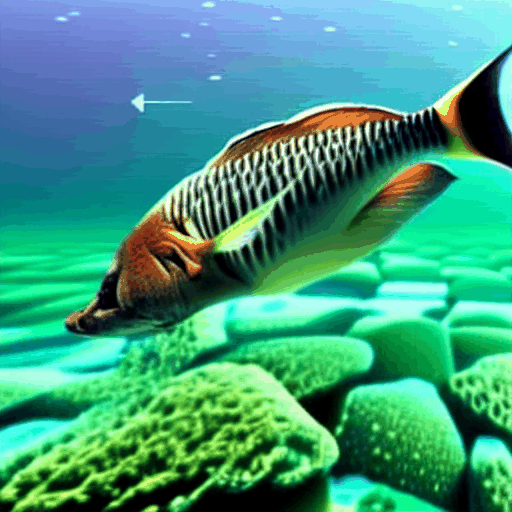

In [17]:
#@markdown Run for generating videos.

prompt = "A fish diving underwater in search of food from right to left" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
use_inv_latent = True #@param {type:"boolean"}
inv_latent_path = "" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 12.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
video_length = 8 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

ddim_inv_latent = None
if use_inv_latent and inv_latent_path == "":
    from natsort import natsorted
    from glob import glob
    import os
    inv_latent_path = natsorted(glob(f"{OUTPUT_DIR}/inv_latents/*"))[-1]
    ddim_inv_latent = torch.load(inv_latent_path).to(torch.float16)
    print(f"DDIM inversion latent loaded from {inv_latent_path}")

with autocast("cuda"), torch.inference_mode():
    videos = pipe(
        prompt,
        latents=ddim_inv_latent,
        video_length=video_length,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_videos_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).videos

save_dir = "./results" #@param {type:"string"}
save_path = f"{save_dir}/{prompt}.gif"
save_videos_grid(videos, save_path)

# display
from IPython.display import Image, display
display(Image(filename=save_path))


In [ ]:
import os
import re
from IPython.display import Video, display

# Parameters for video generation
prompt = "A fish diving underwater in search of food from right to left" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
use_inv_latent = True #@param {type:"boolean"}
inv_latent_path = "" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 12.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
video_length = 8 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

# Load DDIM inversion latent if specified
ddim_inv_latent = None
if use_inv_latent and inv_latent_path == "":
    from natsort import natsorted
    from glob import glob
    inv_latent_path = natsorted(glob(f"{OUTPUT_DIR}/inv_latents/*"))[-1]
    ddim_inv_latent = torch.load(inv_latent_path).to(torch.float16)
    print(f"DDIM inversion latent loaded from {inv_latent_path}")

# Generate the video
with autocast("cuda"), torch.inference_mode():
    videos = pipe(
        prompt,
        latents=ddim_inv_latent,
        video_length=video_length,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_videos_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).videos

# Set up the save path and directory
save_dir = "./results" #@param {type:"string"}
sanitized_prompt = re.sub(r'[^\w\-_\. ]', '_', prompt)
save_path = f"{save_dir}/{sanitized_prompt}.mp4"

os.makedirs(save_dir, exist_ok=True)

# Save the generated video
save_videos_grid(videos, save_path)

# Print the save path for verification
print(f"Video saved to: {save_path}")



DDIM inversion latent loaded from /content/Tune-A-Video/outputs/duck/inv_latents/ddim_latent-300.pt


  0%|          | 0/50 [00:00<?, ?it/s]

Video saved to: ./results/A fish diving underwater in search of food from right to left.mp4


In [ ]:
#@markdown Free runtime memory
exit()